# Code to demonstrate electon density -> energy inversion as per Semeter & Kamalabadi 2005

This can also be found at: https://github.com/rileytroyer/semeter-inversion/blob/main/semeter-inversion-example.ipynb

For instructions on installing msise00 and getting it to run: https://github.com/space-physics/msise00

written by Riley Troyer Fall 2021

In [1]:
# Make sure custom functions are accessible
import sys
sys.path.append(r"/data/projects/new-project-structure/pfisr-energy/")

In [2]:
# Libraries
from datetime import datetime
from matplotlib import pyplot as plt
import logging
import numpy as np
import os
from scipy.interpolate import interp1d

# Disable divide by zero numpy warnings
np.seterr(divide='ignore')
np.seterr(invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Initiate logging
logging.basicConfig(filename = f'../../logs/run-semeter-inversion-test-{datetime.today().date()}.log',
                    encoding='utf-8',
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    level=logging.INFO,
                    datefmt='%Y-%m-%d %H:%M:%S')

## The first thing I do is read in a config file with various parameters that I could change from run to run.

In [4]:
# Read in config file with dictionary of specified inputs
#import config_example as config
import src.config.config_2023_05_25 as config
config_data = config.run_info['config_info']

# Path to pfisr data directory
pfisr_data_dir = config_data['isr_data_dir']

# File with times for events of interest
reference_file = config_data['event_file']

# Get location of PFISR
pfrr_lat = config_data['isr_lat']
pfrr_lon = config_data['isr_lon']

# Define test flux in m^-2 s^-1
F = config_data['test_flux']

# Don't use PFISR data below this altitude in km
pfisr_min_alt = config_data['isr_min_alt']

# Get sensitivity limit of PFISR
pfisr_sensitivity = config_data['isr_sensitivity']

# Altitude in meters to approximate infinity when calculating
#...mass distance
max_msis_alt = config_data['max_msis_alt']

# Maximum number of iterations to run maximum entropy process on
max_iterations = config_data['max_iterations']

# Reduced chi square to aim for
convergence = config_data['convergence']

# Define arrays for altitude and energy bins

# Altitude in meters
#...number of points should be around the same as pfisr data
altitude_bins = config_data['altitude_bins']

# Energies in eV
#...should probably be less than altitude bins to avoid overfitting
energy_bins = config_data['energy_bins']

# Get which chemistry model to use
alpha_type = config_data['alpha_type']

# Get files to run code for
pfisr_files = config.run_info['run_files']

In [5]:
# For example code just use one file
#pfisr_filename = pfisr_files[0]
#pfisr_filename = pfisr_files[12]
# pfisr_filename = pfisr_files[25]
# pfisr_filename = pfisr_files[56]
#pfisr_filename = '20080326.001_bc_1min-fitcal.h5'
#pfisr_filename = pfisr_files[12]
#pfisr_filename = pfisr_files[12]
pfisr_filename = pfisr_files[12]

In [6]:
pfisr_filename

'20161013.003_bc_nenotr_1min.h5'

## Next I read in a file containing information about the $\Lambda$ function as per Semeter & Kamalabadi 2005. More on this later. As well as the file containing the ISR data.

In [7]:
from src.data.pfisr_functions import get_isr_data

In [8]:
# Read in file with energy dissipation function
lambda_filename = '../../models/semeter_kamalabadi_lambda_function.txt'
lambda_data = np.loadtxt(lambda_filename, skiprows=5)

# Create an interpolated function from this
#...values outside set to 0
lambda_interp = interp1d(lambda_data[:, 0], lambda_data[:, 1],
                         bounds_error=False, fill_value=0)

In [9]:
# Read in the pfisr data
(utc_time, unix_time, 
 pfisr_altitude,
 e_density, de_density) = get_isr_data(pfisr_filename, pfisr_data_dir)

## Events of interest are usually only a small portion of the ISR data, so to speed up the analysis it's useful to select only these periods

In [10]:
def find_event_indices(utc_time:np.ndarray) -> list:
    """Function to find only indices of times of interest.
    INPUT
    utc_time - utc datetimes of all pfisr data
    OUTPUT
    slices_n - indices of pfisr data that is of interest
    """
    
    # Find the date for the current pfisr file, this is a little tricky as
    #...some pfisr files span multiple days
    pfisr_dates = np.unique(np.array([d.date() for d in utc_time]))

    # Dates that are in both pa database and pfisr file
    pa_pfisr_dates = np.unique(np.array([d for d in pa_dates 
                                         if d in pfisr_dates]))

    # Loop through each of these dates and get correct indices
    indices = []
    for date in pa_pfisr_dates:
            indices.append(np.argwhere(pa_dates == date))

    # Flatten list of indices
    indices = [item[0] for sublist in indices for item in sublist]

    # Loop through each index and get data slices corresponding to the
    #...start and stop times
    slices_n = []
    for index in indices:

        # Get the date and start time of measurements
        date = pa_database[index, 0]
        start_time = date + ' ' + pa_database[index, 1]
        end_time = date + ' ' + pa_database[index, 2]

        # Convert to datetime
        start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        end_time = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')

        # Find which indices in pfisr data correspond
        slices_n.append(np.argwhere((utc_time >= start_time) 
                                    & (utc_time <= end_time)))

    # Flatten pfisr array indices
    slices_n = [item[0] for sublist in slices_n for item in sublist]
    
    return slices_n

In [11]:
# Read in file with pulsating aurora dates, times and types
pa_database = np.loadtxt(reference_file, delimiter='\t', dtype=str)
pa_database = pa_database[1:, :]

# Convert dates to datetimes
pa_dates = np.array([datetime.strptime(d, '%Y-%m-%d').date() for d 
                     in pa_database[:, 0]])

slices_n = find_event_indices(utc_time)

## For example purposes I'll only consider one time slice of the data. These calculations require information about the atmospheric density at the given time and location. To determine this I will run the MSISE00 model.

In [12]:
from src.models.ne_to_q_functions import get_msis_density

In [13]:
# Time slice to run inversion for
# slice_n = 684
# slice_n = 157
# slice_n = 7
#slice_n = 140

slice_n = 130
print(utc_time[slice_n])

2016-10-13 12:39:56


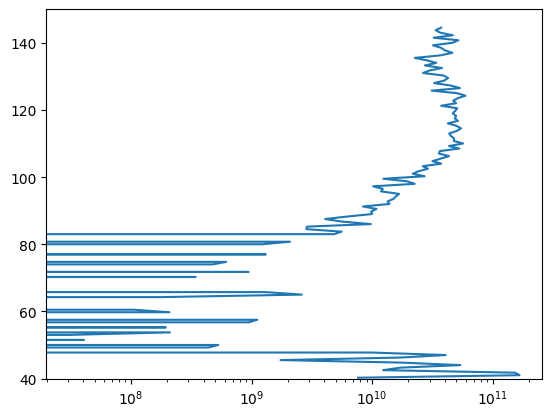

In [14]:
plt.plot(e_density[:, slice_n], pfisr_altitude/1000)
plt.ylim(40, 150)
plt.xscale('log')

In [15]:
# Time associated with slice
run_time = utc_time[slice_n]

# Get MSIS calculated densities
# Disable info logging
(total_msis_alt,
 msis_interp_density) = get_msis_density(run_time, altitude_bins,
                                         max_alt=max_msis_alt,
                                         glat=pfrr_lat, glon=pfrr_lon)

# Get density for altitude bins
total_msis_density = msis_interp_density(total_msis_alt)
density_rho = msis_interp_density(altitude_bins)

## Calculate the mass distance of a particle travelling through the atmosphere. This is defined as 
## $s(z) = \frac{1}{\cos(I)}\int_{z_0}^\infty \, \rho(z)\, dz$
### where $I=0$ is the incident angle of the particles and $\rho(z)$ is the MSISE00 calculated mass density. 
### To approximate $\infty$ I integrate out to 1000 km. I do the integration using the trapezoid method, which seems to be plenty good enough.

In [16]:
from src.models.ne_to_q_functions import mass_distance

In [17]:
# Calculate mass distance (s) for each altitude by integrating
#...out to 1000 km (~infinity)
s = np.array([mass_distance(z, total_msis_density,
                            total_msis_alt) for z in range(len(altitude_bins))])

## The mass distance is needed to calculate the ion production rate. The ion production rate is important since 
## $q(z) = A(z, K) \phi(K)$
### where $z$ is altitude and $K$ is energy. So if we know $q(z)$ we can invert A and get the number flux $\phi(K)$ in the specified energy bins.

## As derived in the paper
## $q(z, K) = \frac{\Lambda(s/R) \rho(z) K F}{35.5 R(K)} $
### where $\Lambda$ is a discrete function defined in a table in the paper, $F$ is a test number flux, and $R$ is a range-energy function.

In [18]:
from src.models.ne_to_q_functions import barrett_hays_range_energy_func

In [19]:
# Calculate ion production rate for each energy and store
#...in dictionary
ion_prod_rate = {}

for i, energy in enumerate(energy_bins):

    # Calculate range-energy value
    R = barrett_hays_range_energy_func(energy)

    # Get the (s/R)(z) for the energy
    s_R = s/R

    # Use s/R to get Lambda function values
    lambda_vals = lambda_interp(s_R)

    # Use all of this to calculate ion production rate as function
    #...of alt
    q = (lambda_vals * density_rho * energy * F) / (35.5 * R)

    # Write to dictionary
    ion_prod_rate[energy] = q

## Calculate the matrix $A$. Each column of this corresponds to an energy bin and is equal to the ion production rate multiplied by the energy bin width and divided by the test flux.

In [20]:
# Construct the A matrix
matrix_A = np.zeros([len(altitude_bins), len(energy_bins)])

# Loop through each energy value
for j in range(len(energy_bins)):

    # Get the size of the energy bin
    #...first bin is from zero to energy
    if j == 0:
        delta_E = energy_bins[j] - 0
    else:
        delta_E = energy_bins[j] - energy_bins[j-1]

    # Set column of matrix
    matrix_A[:, j] = ion_prod_rate[energy_bins[j]] * (delta_E/F)

## To guide the inversion process we will use the ion production rate as seen by the ISR. This is defined as
## $q(z) = \alpha n(z)^2 + \frac{dn}{dt}$
### where $n(z)$ is the ISR measured electron density. We assume $\frac{dn}{dt} = 0$. We believe this is a good assumption during pulsating aurora, where the electron density doesn't change much.
### $\alpha$ is the recombination coefficient. At some point we may include ISR temperatures to calculate this, but for the moment we just use
### $\alpha(z) = 2.5 \times 10^{-12}\, e^{-z/51.2}$ 

## Update: using chemistry code from Steve Kaeppler we can calculate a more accurate ionization rate

In [21]:
from src.models.ne_to_q_functions import recombination_coeff, isr_ion_production_rate

In [22]:
# Get estimated ion production rate and error from isr measurements
(q_estimate, 
 dq_estimate,
 alphas) = isr_ion_production_rate(e_density, de_density,
                                   pfisr_altitude, altitude_bins,
                                   slice_n, unix_time, pfrr_lat, pfrr_lon, alpha_type='stanford',
                                   base_dir='../../')

## Before performing the maximum entropy iterations we need to define an initial number flux

In [23]:
from src.models.mem_functions import estimate_initial_number_flux

In [24]:
# Make an initial guess of the number flux
initial_num_flux = estimate_initial_number_flux(energy_bins, matrix_A)

## Perform the maximum entropy iterations to get an estimated number flux for each energy bin. I run the iterations until the change in $\chi^2$ between the $q(z)_\text{ISR} = \alpha(z) n(z)^2$ and $q(z)_\text{A} = A(z, K) \phi(K)$ is less than the specified amount or the specified number of iterations are reached.

In [25]:
from src.models.mem_functions import maximum_entropy_iteration

In [26]:
# Perform the maximum entropy iterative process
(new_num_flux,
 chi_square,
 dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                             altitude_bins, energy_bins,
                                             matrix_A,
                                             q_estimate, dq_estimate,
                                             max_iterations=max_iterations,
                                             convergence=convergence)

In [27]:
# Store results in dictionary
inversion_results = {}

# Write data to dictionary
d = {'altitude' : altitude_bins,
     'initial_density' : np.sqrt(np.dot(matrix_A,
                                        initial_num_flux)/alphas),
     'modeled_density' : np.sqrt(np.dot(matrix_A,
                                        new_num_flux)/alphas),
     'measured_density' : np.sqrt(q_estimate/alphas),
     'measured_error' : np.sqrt(abs(dq_estimate/alphas)),
     'energy_bins' : energy_bins,
     'modeled_flux' : new_num_flux,
     'chi2' : chi_square,
     'dof' : dof,
     'converged' : converged,
     'units' : 'Values given in meters, seconds, electron-volts.'
    }

inversion_results[run_time] = d

# Clear temporary shared memories files in /dev/shm directory in Linux
try:
    os.system('rm /dev/shm/*')
except Exception as e: logging.info(f'Tried to clear shared memory files from /dev/shm/ {e}.')

rm: cannot remove '/dev/shm/*': No such file or directory


## Plot the ISR number density and modeled number density to see how well fit worked. Also plot energy spectrum.

In [28]:
from src.visualization.mem_plotting_functions import inversion_density_plot

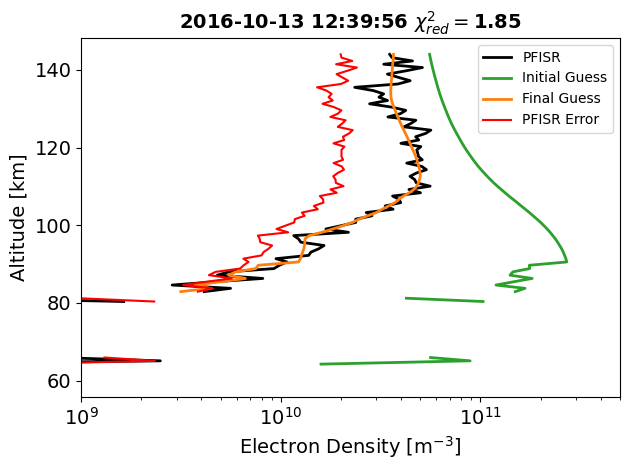

In [29]:
# Plot density
inversion_density_plot(inversion_results, run_time)
# plt.savefig('../LAMP/figures/'
#             + 'density-fit-without-pfisr-correction-2022-03-05.jpg', dpi=200)

In [30]:
from src.visualization.mem_plotting_functions import inversion_numflux_plot

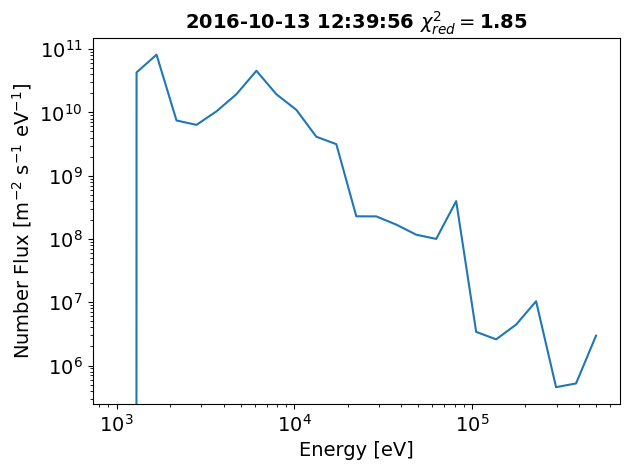

In [31]:
# Plot energy spectrum
inversion_numflux_plot(inversion_results, run_time)
# plt.savefig('../source-energy-pa/figures/paper-figures/'
#             + 'example-spectrum.jpg', dpi=200)

## The following is to compare values between differing ways to estimate the ion production rate from the PFISR measurements.

In [32]:
# Is there SIC data to plot
sic_data = False

In [34]:
(q_vickrey, 
 dq_vickrey, 
 alphas_vickrey) = isr_ion_production_rate(e_density, de_density,
                                   pfisr_altitude, altitude_bins,
                                   slice_n, unix_time, pfrr_lat, pfrr_lon, alpha_type='vickrey',
                                   base_dir='../../')

(q_osepian, 
 dq_osepian, 
 alphas_osepian) = isr_ion_production_rate(e_density, de_density,
                                   pfisr_altitude, altitude_bins,
                                   slice_n, unix_time, pfrr_lat, pfrr_lon, alpha_type='osepian',
                                   base_dir='../../')

(q_gledhill, 
 dq_gledhill, 
 alphas_gledhill) = isr_ion_production_rate(e_density, de_density,
                                   pfisr_altitude, altitude_bins,
                                   slice_n, unix_time, pfrr_lat, pfrr_lon, alpha_type='gledhill',
                                   base_dir='../../')
if sic_data == True:
    (q_sic, 
     dq_sic, 
     alphas_sic) = isr_ion_production_rate(slice_n, alpha_type='sic',
                                           sic_run_num='E01')

In [35]:
# Perform the maximum entropy iterative process
(new_num_flux_vickrey,
 chi_square,
 dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                             altitude_bins, energy_bins,
                                             matrix_A,
                                             q_vickrey, dq_vickrey,
                                             max_iterations=max_iterations,
                                             convergence=convergence)

# Perform the maximum entropy iterative process
(new_num_flux_osepian,
 chi_square,
 dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                             altitude_bins, energy_bins,
                                             matrix_A,
                                             q_osepian, dq_osepian,
                                             max_iterations=max_iterations,
                                             convergence=convergence)

# Perform the maximum entropy iterative process
(new_num_flux_gledhill,
 chi_square,
 dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                             altitude_bins, energy_bins,
                                             matrix_A,
                                             q_gledhill, dq_gledhill,
                                             max_iterations=max_iterations,
                                             convergence=convergence)

if sic_data == True:
    # Perform the maximum entropy iterative process
    (new_num_flux_sic,
     chi_square,
     dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                                 altitude_bins, energy_bins,
                                                 matrix_A,
                                                 q_sic,
                                                 dq_sic)

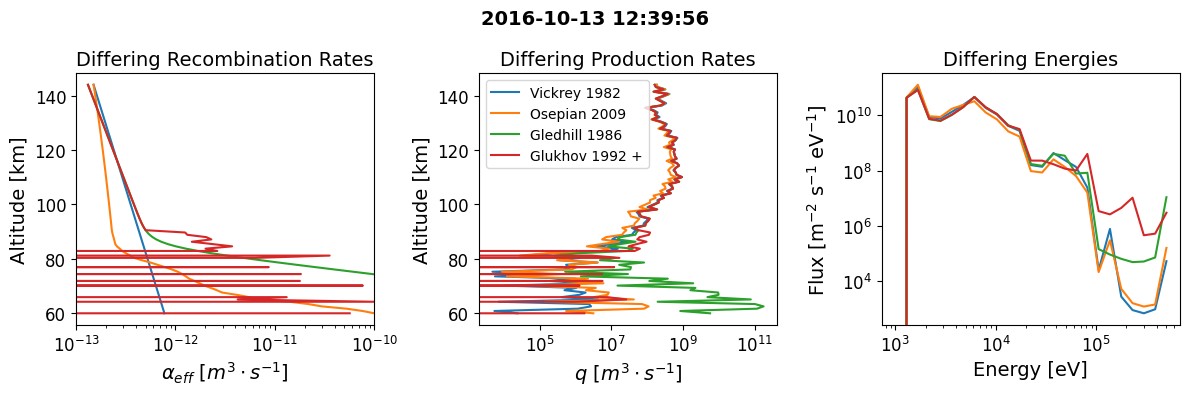

In [37]:
# Plot a comparison between the different recombination coefficients
fig = plt.figure(figsize=(12, 4))

ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2, sharey = ax0)
ax2 = fig.add_subplot(1, 3, 3)

plt.suptitle(str(utc_time[slice_n]), fontsize=14,
              fontweight='bold')

###### Plot 1: ion recombination rates ######
# Title and axis
ax0.set_title('Differing Recombination Rates', 
             fontsize=14)
ax0.set_xlabel(r'$\alpha_{eff}$ $[m^3 \cdot s^{-1}]$', fontsize=14)
ax0.set_ylabel('Altitude [km]', fontsize=14)

# Plot the coefficients
ax0.plot(alphas_vickrey, altitude_bins/1000, label='Vickrey 1982')
ax0.plot(alphas_osepian, altitude_bins/1000, label='Osepian 2009')
ax0.plot(alphas_gledhill, altitude_bins/1000, label='Gledhill 1986')
ax0.plot(alphas, altitude_bins/1000, label='Glukhov 1992 +')

if sic_data == True:
    ax0.plot(alphas_sic, altitude_bins/1000, label='SIC')
    
ax0.set_xscale('log')
ax0.set_xlim(1e-13, 1e-10)
ax0.tick_params(labelsize=12)

###### Plot 2: ion production rates ######
ax1.set_title('Differing Production Rates', 
             fontsize=14)
ax1.set_xlabel(r'$q$ $[m^3 \cdot s^{-1}]$', fontsize=14)
ax1.set_ylabel('Altitude [km]', fontsize=14)

# Plot the rates
ax1.plot(q_vickrey, altitude_bins/1000, label='Vickrey 1982')
ax1.plot(q_osepian, altitude_bins/1000, label='Osepian 2009')
ax1.plot(q_gledhill, altitude_bins/1000, label='Gledhill 1986')
ax1.plot(q_estimate, altitude_bins/1000, label='Glukhov 1992 +')

if sic_data == True:
    ax1.plot(q_sic, altitude_bins/1000, label='SIC')

ax1.set_xscale('log')
ax1.tick_params(labelsize=12)
# yax = ax1.axes.get_yaxis()
# yax = yax.set_visible(False)

ax1.legend()


###### Plot 3: energies ######
ax2.set_title('Differing Energies', fontsize=14)
ax2.set_ylabel(r'Flux [m$^{-2}$ s$^{-1}$ eV$^{-1}$]',
              fontsize=14)
ax2.set_xlabel('Energy [eV]', fontsize=14)
ax2.tick_params(labelsize=12)
ax2.set_xscale('log')
ax2.set_yscale('log')

# Get differential number flux by multiplying by energy bin width
bin_widths = energy_bins - np.roll(energy_bins, shift=1)

# Plot the energy
ax2.plot(energy_bins, new_num_flux_vickrey*bin_widths,
        label='Vickrey 1982')
ax2.plot(energy_bins, new_num_flux_osepian*bin_widths,
        label='Osepian 2009')
ax2.plot(energy_bins, new_num_flux_gledhill*bin_widths,
        label='Gledhill 1986')
ax2.plot(energy_bins, new_num_flux*bin_widths,
         label='Glukhov 1992 +')

if sic_data == True:
    ax2.plot(energy_bins, new_num_flux_sic*bin_widths,
            label='SIC')

plt.tight_layout()

# plt.savefig('../source-energy-pa/figures/semeter-inversion/'
#             'sic-chemistry-comparison/'
#             + 'chemistry-comparison-sic-4.jpg', dpi=200)